In [21]:
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from global_config import Preprocess_config

import torch
import matplotlib.pyplot as plt

In [3]:
from pipline import Datapipline, Wheat_Dataset
from global_config import Preprocess_config
from leaner import AverageMeter,Fitter

from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler


import torch
import torch.nn as nn
from timm.utils import ModelEma
from effdet.anchors import Anchors, AnchorLabeler, generate_detections, MAX_DETECTION_POINTS
from effdet.loss import DetectionLoss

from effdet import get_efficientdet_config, EfficientDet
from effdet.efficientdet import HeadNet

In [4]:
fold_number = Preprocess_config().fold_number
path = Preprocess_config.path
data_pipline = Datapipline(path=path) #imsize controls resize
train_dataset = Wheat_Dataset(
    df=data_pipline.df,
    path=data_pipline.path,
    image_ids=data_pipline.df_folds[data_pipline.df_folds['fold'] != fold_number].index.values,
    transform=data_pipline.get_train_transforms(),
)

validation_dataset = Wheat_Dataset(
    df=data_pipline.df,
    path=data_pipline.path,
    image_ids=data_pipline.df_folds[data_pipline.df_folds['fold'] == fold_number].index.values,
    transform=data_pipline.get_valid_transforms(),
    test=True,
)

In [10]:
#import torch
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2



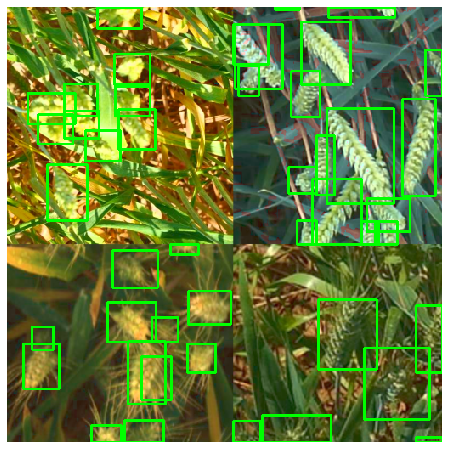

In [11]:

image, target, image_id = train_dataset[random.randint(0,300)]
boxes = target['bbox'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

In [5]:
class TrainGlobalConfig:
    num_workers = 8
    batch_size = 8
    n_epochs = 40 # n_epochs = 40
    lr = 0.0002

    folder = 'test_delete'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = True  # do scheduler.step after optimizer.step
    validation_scheduler = False  # do scheduler.step after validation stage loss

    SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
    scheduler_params = dict(
        max_lr=1e-3,
        epochs=n_epochs,
        steps_per_epoch=int(len(train_dataset) / batch_size),
        pct_start=0.2,
        anneal_strategy='cos', 
        final_div_factor=10**5
    )
    
#     SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
#     scheduler_params = dict(
#         mode='min',
#         factor=0.5,
#         patience=1,
#         verbose=False, 
#         threshold=0.0001,
#         threshold_mode='abs',
#         cooldown=0, 
#         min_lr=1e-8,
#         eps=1e-08
#     )

In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [7]:
class DetBenchTrain(nn.Module):
    def __init__(self, model, config):
        super(DetBenchTrain, self).__init__()
        self.config = config
        self.model = model
        self.anchors = Anchors(
            config.min_level, config.max_level,
            config.num_scales, config.aspect_ratios,
            config.anchor_scale, config.image_size)
        self.anchor_labeler = AnchorLabeler(self.anchors, config.num_classes, match_threshold=0.5)
        self.loss_fn = DetectionLoss(self.config)

    def forward(self, x, target):
        class_out, box_out = self.model(x)
        cls_targets, box_targets, num_positives = self.anchor_labeler.batch_label_anchors(
            x.shape[0], target['bbox'], target['cls'])
        loss, class_loss, box_loss = self.loss_fn(class_out, box_out, cls_targets, box_targets, num_positives)
        output = dict(loss=loss, class_loss=class_loss, box_loss=box_loss)
#         if not self.training:
#             # if eval mode, output detections for evaluation
#             class_out, box_out, indices, classes = _post_process(self.config, class_out, box_out)
#             output['detections'] = _batch_detection(
#                 x.shape[0], class_out, box_out, self.anchors.boxes, indices, classes,
#                 target['img_scale'], target['img_size'])
        return output

In [8]:


def get_net():
    config = get_efficientdet_config(Preprocess_config().model)
    net = EfficientDet(config, pretrained_backbone=True)
    #checkpoint = torch.load('../input/efficientdet/efficientdet_d5-ef44aea8.pth')
    #net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

net = get_net()

In [9]:
run_training()

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Fitter prepared. Device is cuda:0

2020-06-25T22:00:37.681498
LR: 3.9999999999999996e-05
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
[RESULT]: Train. Epoch: 0, summary_loss: 11.79376, time: 210.991

NameError: name 'glob' is not defined